# SDE simulations and statistics

## Contents
   - [Brownian motion](#sec1)
      - [Confidence interval](#sec1.2)
      - [Hypothesis testing](#sec1.3)
   - [Geometric Brownian motion](#sec2)
   - [CIR process](#sec3)
      - [Euler-Maruyama method](#sec3.1)
      - [Parameter estimation](#sec3.2)
      - [Change of variables](#sec3.3)

In [2]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.special import iv
from scipy.optimize import minimize

<a id='sec1'></a>
# Brownian motion

Let us simulate some Brownian paths.    
Remember that the (standard) Brownian motion $\{X_t\}_{t\geq 0}$ is a continuous time stochastic process, that satisfies the following properties:
- $X_{0} = 0$.
- The increments are stationary and independent. (see **A3** for the definition)
- It is a martingale.
- It has continuous paths, but nowhere differentiable.
- $X_t - X_s \sim \mathcal{N}(0,t-s)$ for $t\geq s \geq 0$.

For more info see here [wiki](https://en.wikipedia.org/wiki/Brownian_motion).

In our simulation, each increments is such that:

$$ X_{t_i+\Delta t} - X_{t_i} = \Delta X_i \sim \mathcal{N}(\mu \Delta t,\, \sigma^2 \Delta t). $$

The process at time T is given by $X_T = \sum_i \Delta X_i$ and follows the distribution:

$$ X_T \sim \mathcal{N}(\mu T,\, \sigma^2 T). $$

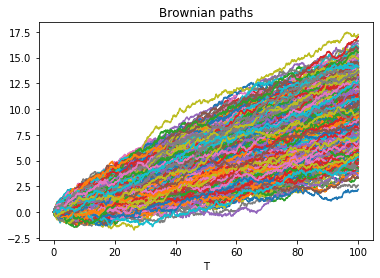

In [25]:
#scipy.stats uses numpy.random to generate its random numbers
np.random.seed(seed=42)   

paths=4000              # number of paths
steps=1000             # number of time steps

mu = 0.1               # drift 
sig = 0.2              # diffusion coefficient or volatility 
T = 100                
T_vec, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths,1))        # each path starts at zero
increments = ss.norm.rvs(loc=mu*dt, scale=np.sqrt(dt)*sig, size=(paths,steps-1))

X = np.concatenate((X0,increments), axis=1).cumsum(1)

plt.plot(T_vec,X.T); plt.title("Brownian paths"); plt.xlabel("T")
plt.show()

Now we consider the terminal values of each path.  These values should give us some indications about the distribution of $X_T$.

We expect to have $\mathbb{E}[X_T] = \mu T$ and $Std[X_T] = \sigma \sqrt{T}$.

In [26]:
X_end = X[:,-1]
print("Expectation of X at time T: {:.4f}".format(X_end.mean()) )
print("Standard Deviation of X at time T: {:.4f}".format(X_end.std(ddof=1)) )

Expectation of X at time T: 9.9827
Standard Deviation of X at time T: 1.9964


Here I'm using the unbiased standard deviation estimator, with one degree of freedom i.e. `ddof=1`. Since the number of steps is quite big, there is no big difference between this and other possible estimators.    
Let us recall that a common alternative is the MLE (maximum likelihood estimator), with `ddof=0`.

<a id='sec1.2'></a>
## Confidence intervals

Ok... what we have seen so far was quite easy. Right? 

But... we want to be precise!  We want to associate a confidence interval to each estimated parameter!    
In other words, we want to indicate how close the sample statistic (the estimated parameter) is to the population parameter (the real value of the parameter).

We can find an interval of values that contains the real parameter, with a confidence level of $(1-\alpha)100\%$, for $0<\alpha<1$. This is called **confidence interval**.

Let us introduce some basic concepts:

Let $X_i$ i.i.d (independent and identical distributed), for $1\leq i \leq n$, with $\mathbb{E}[X_i]=\mu$ and $Var[X_i] = \sigma^2$.    
We call $\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i$.
- $\bar{X}$ has expectation: $\mathbb{E}[\bar{X}] = \frac{1}{n}\sum_{i=1}^n \mathbb{E}[X_i] = \mu$.
- $\bar{X}$ has variance: $Var[\bar{X}] = \frac{1}{n^2} Var[\sum_{i=1}^n X_i] = \frac{1}{n^2} \sum_{i=1}^n Var[X_i] = \frac{\sigma^2}{n}$.
- Central limit theorem: $$ Z_n = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} \underset{n\to \infty}{\to} Z \sim \mathcal{N}(0,1) $$

##### Normal distributed variables 
For $Z \sim \mathcal{N}(0,1)$, we call $z_{\alpha/2}$ the value such that:

$$ \mathbb{P}(Z< -z_{\alpha/2}) = \mathbb{P}(Z > z_{\alpha/2}) = \alpha/2 $$

Let $X_i \sim \mathcal{N}(\mu,\sigma^2)$. **Let us assume $\sigma$ is known**.

The sum of normal random variables is again normal, i.e. 
$\sum_{i=1}^n X_i \sim \mathcal{N}(n\mu,n\sigma^2)$, therefore we have that $\bar{X} \sim \mathcal{N}(\mu,\frac{\sigma^2}{n})$. We can standardize and obtain $Z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} \sim \mathcal{N}(0,1) $.     

We can write:

$$ \begin{aligned}
(1 - \alpha) &= \mathbb{P} \biggl( -z_{\alpha/2} < \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}} < z_{\alpha/2} \biggr) \\
             &= \mathbb{P} \biggl(\bar{X} - z_{\alpha/2} \frac{\sigma}{\sqrt{n}} <  \mu < \bar{X} + z_{\alpha/2} \frac{\sigma}{\sqrt{n}} \biggr)
\end{aligned} $$

Then, the $(1 - \alpha)100\%$ confidence interval for the mean $\mu$ is:

$$ \biggr[ \bar{x} - z_{\alpha/2} \frac{\sigma}{\sqrt{n}} \, , \; \bar{x} + z_{\alpha/2} \frac{\sigma}{\sqrt{n}} \biggr] $$

where $\bar{x}$ is one realization of $\bar{X}$.    
Recall that confidence intervals are random variables, and can have different values for different samples!

Usually it is common to calculate the $95\%$ confidence interval.     
For a $95\%$ confidence interval, $1-\alpha = 0.95$, so that $\alpha/2 = 0.025$, and $z_{0.025} = 1.96$.

Let $X_i \sim \mathcal{N}(\mu,\sigma^2)$. **Let us assume $\sigma$ is unknown**.

We can consider instead the [sample variance](https://en.wikipedia.org/wiki/Variance#Sample_variance) (unbiased version, $\mathbb{E}[S^2] = \sigma^2$):

$$ S^2 = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2 $$
and the statistics
$$ T = \frac{\bar{X} - \mu}{\frac{S}{\sqrt{n}}} $$

Let us recall that:
- $\bar{X}$ and $S^2$ are independent.
- $S^2 \sim \frac{\sigma^2}{n-1} \chi^2_{n-1}.$
- $T \sim t_{n-1}$ (**student t distribution**) [wiki]().

Following the same steps as above, we can compute the **t-confidence interval for the mean**:

$$ \biggr[ \bar{x} - t_{\alpha/2,n-1} \frac{s}{\sqrt{n}} \, , \; \bar{x} + t_{\alpha/2,n-1} \frac{s}{\sqrt{n}} \biggr] $$

where $\bar{x}$ and $s$ are realizations of $\bar{X}$ and $S$.    
For $T \sim t_{n-1}$, we call $t_{\alpha/2,n-1}$ the value such that: 

$$ \mathbb{P}(T< -t_{\alpha/2,n-1}) = \mathbb{P}(T > t_{\alpha/2,n-1}) = \alpha/2. $$

Recall that the student t density is symmetric.     
The term $\frac{s}{\sqrt{n}}$ is called **standard error** for the mean.

##### Non-normal data

Thanks to the central limit theorem, the ratio $\frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}}$ approaches a standard normal distribution for $n$ big enough.  In general $n>30$ is enough.    

For big $n$ the values of $t_{\alpha/2,n-1}$ and $z_{\alpha/2}$ are very close. Therefore they are interchangeable.

#### Confidence intervals for the variance

The Chi-square distribution is asymmetric, therefore we define $a = \chi^2_{1-\alpha/2,n-1}$ and $b = \chi^2_{\alpha/2,n-1}$ and write:

\begin{align*}
(1 - \alpha) &= \mathbb{P} \biggl( a < \frac{(n-1) S^2}{\sigma^2} < b \biggr) \\
             &= \mathbb{P} \biggl( \frac{(n-1) S^2}{b} <  \sigma^2 < \frac{(n-1) S^2}{a} \biggr)
\end{align*}

The confidence interval for the variance is therefore:

$$ \biggl[ \frac{(n-1) S^2}{b} \, , \, \frac{(n-1) S^2}{a} \biggr] .$$

For the standard deviation $\sigma$, the confidence interval is:

$$ \biggl[ \sqrt{\frac{(n-1) S^2}{b}} \, , \, \sqrt{\frac{(n-1) S^2}{a}} \biggr] .$$

###### A step back
Ok... cool... a lot of theory.     
Let's see how it works in practice for the terminal value of the Brownian motion $X_T$. 

In [27]:
print("The expectation of the mean is: {:.6f}".format(X_end.mean()) )
print("The confidence interval is: ", ss.t.interval(0.95, paths-1, loc=X_end.mean(), scale=ss.sem(X_end)) )

The expectation of the mean is: 9.982654
The confidence interval is:  (9.920766648111108, 10.044541975623869)


In [28]:
s2 = X_end.var(ddof=1)   # unbiased sample variance
AA = s2 * (paths-1) 
print("The estimated Standard Deviation is: {:.6f}".format(X_end.std(ddof=1)) )
print("The confidence interval is: ", \
      np.sqrt(AA / ss.chi2.ppf(0.975, df=paths-1)), np.sqrt(AA / ss.chi2.ppf(0.025, df=paths-1)) )

The estimated Standard Deviation is: 1.996432
The confidence interval is:  1.9536249339404514 2.041170826805831


##### Sometimes the confidence interval fails!

We chose a $95\%$ confidence interval. This means that $5\%$ of the times it fails!

In the following cell, I want to check how many times the confidence interval fails to contain the population mean (in this case it is $\mu T = 10$), if we repeat the experiment 100 times. For this purpose we just need to change the seed of the random number generator.

In [29]:
for n in range(100):
    np.random.seed(seed=n)
    XT = ss.norm.rvs(loc=mu*T, scale=np.sqrt(T)*sig, size=paths)
    low = ss.t.interval(0.95, paths-1, loc=XT.mean(), scale=ss.sem(XT))[0]
    high = ss.t.interval(0.95, paths-1, loc=XT.mean(), scale=ss.sem(XT))[1]
    if (mu*T < low) or (mu*T > high):
        print("seed:", n, '\n', mu*T, "is not contained in ", (low.round(4),high.round(4)) )

seed: 23 
 10.0 is not contained in  (9.8494, 9.9735)
seed: 68 
 10.0 is not contained in  (9.875, 9.9985)
seed: 99 
 10.0 is not contained in  (10.0291, 10.1555)


**Well... it failed 3 times!!**

The parameters can be estimated by the following `scipy.stats` function:

In [30]:
param = ss.norm.fit(X_end)
print("Parameters from the fit: ", param) # these are MLE parameters
print("The MLE estimator for the standard deviation is: ", np.std(X_end, ddof=0) )

Parameters from the fit:  (9.982654311867488, 1.9961824533945993)
The MLE estimator for the standard deviation is:  1.9961824533945993


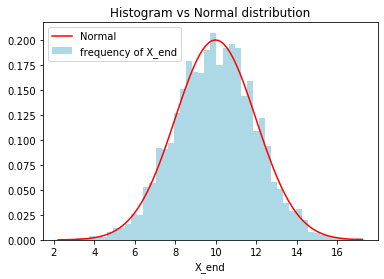

In [34]:
x = np.linspace(X_end.min(), X_end.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

plt.plot(x, pdf_fitted, color='r', label="Normal")
plt.hist(X_end, density=True, bins=50, facecolor="LightBlue", label="frequency of X_end")
plt.legend(); plt.title("Histogram vs Normal distribution"); plt.xlabel("X_end")
plt.show()

<a id='sec1.3'></a>
## Hypothesis testing

Hypothesis testing is a broad topic. It is hard to summarize it here.    
A summaru of the topic can be found here [statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). The two fundamental concepts to understand are: the [Test Statistic](https://en.wikipedia.org/wiki/Test_statistic)
and the [p-value](https://en.wikipedia.org/wiki/P-value). 

For what concerns practical applications, only the **p-value** is necessary. 
It is the probability of obtaining values of the test statistic more extreme than those observed in the data, assuming the null hypothesis $H_0$ being true.     
The p-value is the smallest significance level $\alpha$ that leads us to rejecting the null hypothesis.

Here I want to use some "classical tests" for testing the normality of $X_T$. 
- **Shapiro-Wilk**, [doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)      
  The null hypothesis $H_0$ is that the data are normally distributed.    
  It returns the test statistics and the p-value.
- **Jarque-Bera** [doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html)     
  The null hypothesis $H_0$ is that the data are normally distributed.    
  It returns the test statistics and the p-value. 
- **Kolmogorov-Smirnov**, [doc](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html)    
  It compares two distributions.     
  The null hypothesis $H_0$ assumes the two distributions identical.

Other common tests are: The [Anderson-Darling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson) test and the [D'Agostino](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) test.

It is also quite useful to visualize the **Q-Q plot**.


- Shapiro - Wilk:

In [35]:
ss.shapiro(X_end)   

(0.9995095729827881, 0.41248953342437744)

Assuming a confidence level of $95\%$. Since the p-value is not smaller that 0.05, we cannot reject $H_0$.

- Jarque - Bera:

In [36]:
ss.jarque_bera(X_end)  

(1.8821352125475588, 0.39021102116709205)

Assuming a confidence level of $95\%$. Since the p-value is not smaller that 0.05, we cannot reject $H_0$.

- Kolmogorov - Smirnov:

In [37]:
ss.kstest(X_end, lambda x: ss.norm.cdf(x,loc=10, scale=2) )

KstestResult(statistic=0.010299978780936525, pvalue=0.7897982616019145)

Assuming a confidence level of $95\%$. Since the p-value is not smaller that 0.05, we cannot reject $H_0$.

- Q-Q plot:

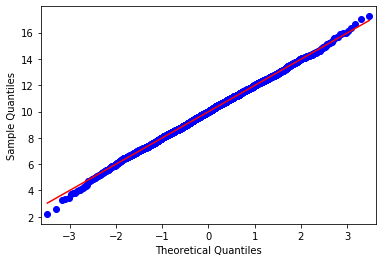

In [38]:
qqplot(X_end, line='s');  plt.show()

<a id='sec2'></a>
# Geometric Brownian Motion

The GBM has the following stochastic differential equation (SDE):

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

By applying the Itô lemma on $\log S_t$ it is possible to solve this equation (see the computations [here](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)).     
The solution is:

$$ S_t = S_0 e^{(\mu-\frac{1}{2}\sigma^2)t + \sigma W_t} $$

In [14]:
np.random.seed(seed=42) 
mu = 0.1
sig = 0.2
T = 10
N = 10000 
S0 = 1

W = ss.norm.rvs( loc=(mu - 0.5 * sig**2)*T, scale=np.sqrt(T)*sig, size=N )
S_T = S0 * np.exp(W)

When we consider a lognormal random variable $S \sim LN(\mu, \sigma^2)$,
the two parameters $\mu$ and $\sigma$ are not the location and scale parameters of the lognormal distribution.    
They are respectively the location and scale parameters of the normally distributed $\ln S \sim \mathcal{N}(\mu,\sigma^2)$.    

Using our specific notation $S \sim LN(\mu -\frac{1}{2}\sigma^2, \sigma^2)$, the scale parameter is $e^{(\mu-\frac{1}{2}\sigma^2)T }$ and the shape parameter is $\sigma \sqrt{T}$.    
The location is zero, because the distribution starts at zero. (changing the $loc$ parameter would shift the support of the distribution on the domain $[loc,\infty]$ )

In [15]:
param_LN = ss.lognorm.fit(S_T)
print("Fitted parameters: ", param_LN)
print("Shape: ", sig*np.sqrt(T) )
print("Scale: ", np.exp((mu - 0.5 * sig**2)*T))

Fitted parameters:  (0.6335031590210367, -0.0031793067974526315, 2.226428161130303)
Shape:  0.632455532033676
Scale:  2.225540928492468


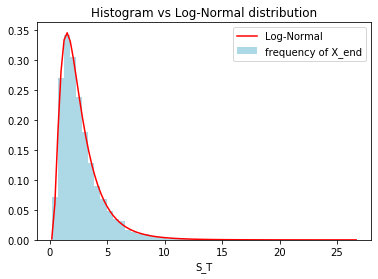

In [16]:
x = np.linspace(S_T.min(), S_T.max(), 100)
pdf_LN_fitted = ss.lognorm.pdf(x, *param_LN)

plt.plot(x, pdf_LN_fitted, color='r', label="Log-Normal")
plt.hist(S_T, density=True, bins=50, facecolor="LightBlue", label="frequency of X_end")
plt.legend(); plt.title("Histogram vs Log-Normal distribution"); plt.xlabel("S_T")
plt.show()

##### Parameter estimation:

In order to estimate the parameters, we need to take first the logarithm of the data!

The variable of interest is
$$\log S_T \sim \mathcal{N} \biggl( (\mu-\frac{1}{2}\sigma^2)T, \sigma^2 T \biggr)$$

Now we can estimate the mean and the variance of a Normal distributed sample. This is quite easy!

In [17]:
std_S = np.std(np.log(S_T), ddof=0 )/np.sqrt(T)
mu_S = np.mean(np.log(S_T))/T + 0.5 * std_S**2

print("Volatility or coefficient sig: ", std_S.round(6))
print("Drift or coefficient mu: ", mu_S.round(6))

Volatility or coefficient sig:  0.200682
Drift or coefficient mu:  0.100002


##### Path simulation

There is no need to use advanced techniques.     

If we want to simulate GBM paths, it is enough to simulate Brownian paths (with the adjusted drift) and then take their exponentials!



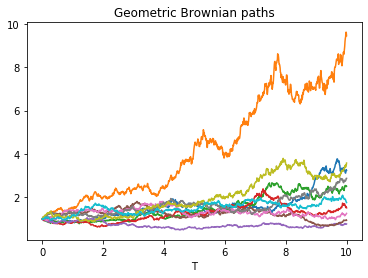

In [18]:
np.random.seed(seed=42) 
paths=10              # number of paths
steps=1000            # number of time steps
T = 10                
T_vec, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths,1))        # each path starts at zero
W = ss.norm.rvs( (mu - 0.5 * sig**2)*dt, np.sqrt(dt)*sig, (paths,steps-1))
X = np.concatenate((X0,W), axis=1).cumsum(1)

S_T = np.exp(X)
plt.plot(T_vec, S_T.T ); plt.title("Geometric Brownian paths"); plt.xlabel("T")
plt.show()

<a id='sec3'></a>
# CIR process

The Cox-Ingersoll-Ross process [CIR](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model) is described by the SDE: 

$$ dX_t = \kappa (\theta - X_t) dt + \sigma \sqrt{X_t} dW_t $$

The parameters are:
- $\kappa$ mean reversion coefficient
- $\theta$ long term mean  
- $\sigma$  volatility coefficient

If $2\kappa \theta > \sigma^2$ (Feller condition), the process is always strictly positive!

**Curiosity for mathematicians**     
The diffusion coefficient of the CIR equation does not satisfy the Lipschitz conditions (square root is not Lipschitz)!!  However, it can be proved that the CIR equation admits a unique solution. 

Here I recall a common method used to solve SDEs. [wiki](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)

<a id='sec3.1'></a>
## Euler Maruyama method

Let us divide the time interval $[0,T]$ in 
$$0=t_0, t_1, ..., t_{n-1}, t_n=T.$$      
We can choose equally spaced points $t_i$ such that $\Delta t = t_{i+1} - t_i = \frac{T}{N}$ for each $1 \leq i \leq N$.

A generic Itô-Diffusion SDE

\begin{align*}
&dX_t = \mu(t,X_t) dt + \sigma(t, X_t) dW_t \\
&X_0 = 0
\end{align*}

can be approximated by:

\begin{align*}
& X_{i+1} = X_i + \mu(t_i,X_i) \Delta t + \sigma(t_i, X_i) \Delta W_i \\
&X_0 = 0
\end{align*}

with $X(t_i) = X_i$ and $W(t_i) = W_i$.     
The quantity to simulate is $W_{i+1} - W_i = \Delta W_i \sim \mathcal{N}(0, \sqrt{\Delta t})$.

Applying this method to the CIR SDE we obtain:

$$ X_{i+1} = X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{X_i} \Delta W_i $$

Despite the presence of the Feller condition, when we discretize the process, it is possible that $X_i$ becomes negative, creating problems for the evaluation of the square root.    
Here I summarize the most common methods to overcome this problem:

1) $ X_{i+1} = X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{X_i^+} \Delta W_i $

2) $ X_{i+1} = X_i + \kappa (\theta - X_i^+) \Delta t + \sigma \sqrt{X_i^+} \Delta W_i $

3) $ X_{i+1} = X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{|X_i|} \Delta W_i $

4) $ X_{i+1} = |X_i + \kappa (\theta - X_i) \Delta t + \sigma \sqrt{X_i} \Delta W_i |$

where ^+ indicates the positive part.     
The method 1) 2) and 3) just resolve the square root problem, but the process can still become negative.   
The method 4) prevent this possibility!

Let us show the implementation of the **method 4)**

In [3]:
%%time
np.random.seed(seed=42) 

N = 200001        # time steps 
paths = 2000      # number of paths 
T = 3
T_vec, dt = np.linspace(0,T,N, retstep=True ) 

kappa = 4 
theta = 1 
sigma = 0.5     
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation

X0 = 2
X = np.zeros((paths,N))
X[:,0] = X0
W = ss.norm.rvs( loc=0, scale=np.sqrt(dt), size=(paths,N-1) )

for t in range(0,N-1):
    X[:,t+1] = np.abs( X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(X[:,t]) * W[:,t] )

X_T = X[:,-1]    # values of X at time T
X_1 = X[1,:]     # a single path

CPU times: user 41.9 s, sys: 3.08 s, total: 45 s
Wall time: 45 s


In [4]:
print("Feller condition is: ", 2*kappa * theta > sigma**2 )

Feller condition is:  True


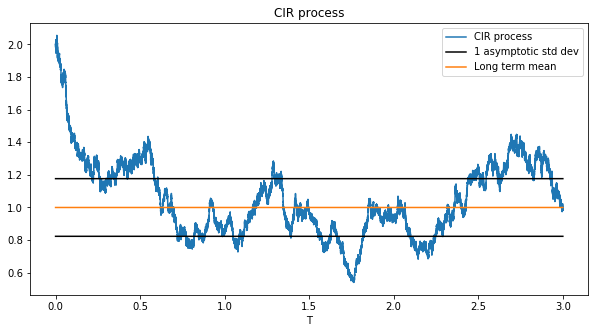

In [5]:
plt.figure(figsize=(10,5))
plt.plot(T_vec, X_1, label="CIR process")
plt.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
plt.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
plt.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
plt.legend(loc="upper right"); plt.title("CIR process"); plt.xlabel("T")
plt.show()

In the plot above I also included the asymptotic mean and standard deviation:

$$ \mathbb{E}[X_T|X_0] \underset{T\to \infty}{\to} \theta $$    
$$ Var[X_T|X_0] \underset{T\to \infty}{\to} \frac{\theta \sigma^2}{2\kappa} $$    

You can find the formulas [here](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model).

Let us also recall that the conditional distribution of $X_T$ is a (scaled) non-central Chi-Squared distribution:

$$ X_T \sim \frac{Y}{2c} $$

with $c=\frac{2\kappa}{(1-e^{-kT})\sigma^2}$ and $Y$ following the non-central $\chi^2$ distribution:

$$ f\bigl( y|x_0;\, K,\lambda \bigr) = \frac{1}{2} e^{-\frac{(\lambda+y)}{2} } \biggl( \frac{y}{\lambda} \biggr)^{ \frac{K-2}{4} } I_{ \frac{K-2}{2} } (\sqrt{\lambda y})  $$

with $K=\frac{4\theta \kappa}{\sigma^2}$ degrees of freedom and non-centrality parameter $\lambda = 2 c X_0 e^{-\kappa T}$.   (`scipy.stats.ncx2` uses this parameterization, see [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html))

After the variable transformation, the density of $X_T$ is:

$$ f(x|x_0; \kappa,\theta,\sigma) = c e^{-(u+v)} \biggl( \frac{v}{u} \biggr)^{q/2} I_q(2\sqrt{uv})  $$

with $q = \frac{2\theta \kappa}{\sigma^2} - 1$,  $u = c x_0 e^{-\kappa T}$, $v = c x$. 

The function $I_q$ is a modified Bessel function of first kind.  See [1] for more details.

The two parameterizations are related by $K=2q+2$ and $\lambda=2u$.

In [30]:
def CIR_pdf(x, x0, T, k, t, s):
    """
    Density of the CIR process
    x: array value
    x0: starting point, 
    T: terminal time, 
    k,t,s: kappa, theta, sigma
    """
    c = 2*k / ((1-np.exp(-k*T))*s**2)
    q = 2*k*t / s**2 - 1
    u = c*x0*np.exp(-k*T)  
    v = c * x
    
    return c * np.exp(-u-v) * (v/u)**(q/2) * iv(q, 2*np.sqrt(u*v))

<a id='sec3.2'></a>
## Parameters estimation

#### OLS

We can rewrite the equation as:

$$ \frac{X_{i+1} - X_i}{\sqrt{X_i}} = \frac{\kappa \theta \Delta t}{\sqrt{X_i}} - \kappa \sqrt{X_i} \Delta t + \sigma \Delta W_i. $$

Now we can find the parameters by OLS. 

$$ (\hat{\kappa}, \hat{\theta}) = \arg \min_{\kappa,\theta} \sum_{i=0}^{N-2} \biggl( \frac{X_{i+1} - X_i}{\sqrt{X_i}} - \frac{\kappa \theta \Delta t}{\sqrt{X_i}} + \kappa \sqrt{X_i} \Delta t \biggr)^2 $$

After a lot of calculations, it is possible to find an expression for $(\hat{\kappa}, \hat{\theta})$.  I will not write it in latex (it is long), but just in python in the following cell. 

We call:
- $YY = \frac{X_{i+1} - X_i}{\sqrt{X_i}} $.    
- $XX_1 = \frac{1}{\sqrt{X_i}} $.     
- $XX_2 = \sqrt{X_i} $.     

The parameter $\sigma$ can be estimated from the residuals. The choice of `ddof=2` is common when estimating the standard deviation of residuals in linear regressions (it corresponds to the number of parameters already estimated).


In [7]:
# formulas for the OLS estimators kappa and theta
num = N**2 - 2*N + 1 + sum(X_1[1:]) * sum(1/X_1[:-1]) \
                - sum(X_1[:-1]) * sum(1/X_1[:-1]) - (N-1) * sum(X_1[1:]/X_1[:-1])
den = (N**2 - 2*N + 1 - sum(X_1[:-1]) * sum(1/X_1[:-1]) ) * dt
kappa_OLS = num/den
theta_OLS = ((N-1) * sum(X_1[1:]) - sum(X_1[1:]/X_1[:-1]) * sum(X_1[:-1]) ) / num

# residuals of the regression
YY = (X_1[1:] - X_1[:-1])/np.sqrt(X_1[:-1])   # response variable
XX1 = 1 / np.sqrt(X_1[:-1])                   # regressor 1 
XX2 = np.sqrt(X_1[:-1])                       # regressor 2
sigma_OLS = np.std(YY - theta_OLS * kappa_OLS * dt * XX1 + dt * kappa_OLS * XX2, ddof=2 )/ np.sqrt(dt)
print("kappa OLS: ", kappa_OLS)
print("theta OLS: ", theta_OLS)
print("sigma OLS: ", sigma_OLS)

kappa OLS:  4.456356687802874
theta OLS:  0.9783705727798766
sigma OLS:  0.5003617989457074


If you are lazy... and you don't want to read, write or understand this extremely long OLS formula, you can use a solver for minimizing the sum of the squares. 

Here I use the `scipy.optimize` function [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

There are several algorithms that work quite well. An alternative to Nelder-Mead can be the L-BFGS-B algorithm.    
Since the variables are positive, I'm also specifying the bounds (but it helps only for L-BFGS-B).

The coefficients are given in the last row. We can see that they coincide with those obtained before.

In [8]:
def least_sq(c):
    return sum((YY - c[1] * c[0] * dt * XX1 + dt * c[0] * XX2)**2)

minimize(least_sq, x0=[1,1], method='Nelder-Mead', bounds=[[1e-15,None],[1e-15,None]], tol=1e-8) # L-BFGS-B

/opt/conda/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


 final_simplex: (array([[4.45633236, 0.97837109],
       [4.45633237, 0.97837109],
       [4.45633237, 0.97837109]]), array([0.75107828, 0.75107828, 0.75107828]))
           fun: 0.7510782789840907
       message: 'Optimization terminated successfully.'
          nfev: 157
           nit: 75
        status: 0
       success: True
             x: array([4.45633236, 0.97837109])

Of course, if you change the initial parameters of the simulation, the estimation procedure can give different results.

I tried to change the seed, several times.    
After some trials, I found that $\kappa$ is the most "volatile" parameter, while $\theta$ and $\sigma$ are quite stable.


Finally, let us compare the density with the histogram of all realizations of $X_T$.

We can also use the `scipy.stats.ncx2` ([doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html)) class to fit the scaled Non-Central Chi-Squared density. However, the results can be very different. 

I will plot the density of $X_T$ under these wrong parameters, and compare it with the right density in the picture below. The two densities are very close!

In practice, when we don't know the values of the original parameters, it is always better to try several calibratition techniques and then compare them!

In [91]:
param_Chi2 = ss.ncx2.fit(X_T)    # fit parameters
print("Parameters from the scipy fit: \n Degrees of freedom: {} \n \
Non-Centrality: {} \n Location: {} \n Scale: {} ".format(*param_Chi2) )

Parameters from the scipy fit: 
 Degrees of freedom: 29.07865663614399 
 Non-Centrality: 29.497594667208162 
 Location: 0.21146560859835073 
 Scale: 0.013445207387043327 


The `CIR_pdf` function defined above, corresponds to the function `ss.ncx2.pdf` 
after the change of parameterization.

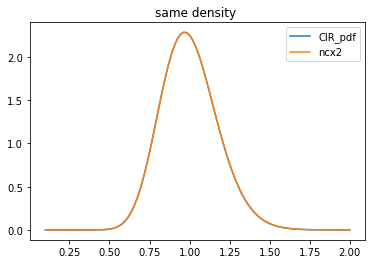

In [102]:
xxx = np.linspace(0.1, 2, 100)

c = 2*kappa / ((1-np.exp(-kappa*T))*sigma**2)
q = 2*kappa*theta / sigma**2 -1
u = c*X0*np.exp(-kappa*T) 
df = 2*q+2                       # parameter K
nc = u*2                         # parameter lambda

plt.plot(xxx, CIR_pdf(xxx, X0, T, kappa, theta, sigma), label="CIR_pdf")
plt.plot(xxx, ss.ncx2.pdf(xxx, df, nc, scale=1/(2*c)), label="ncx2")
plt.legend(); plt.title("same density "); plt.show()

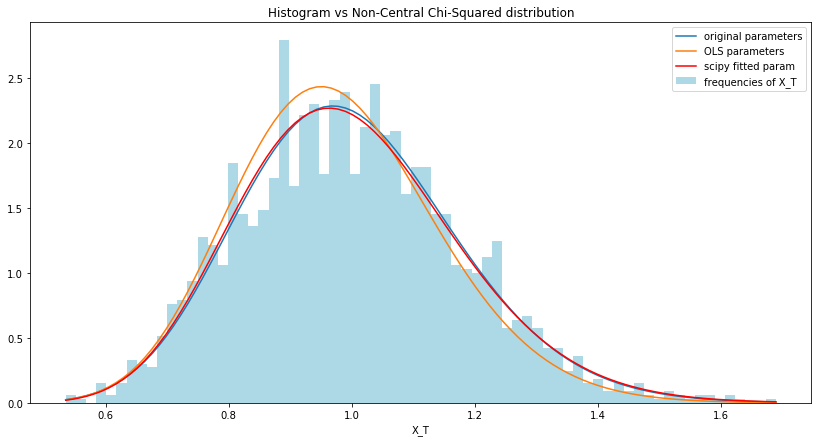

In [105]:
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_Chi2_fitted = ss.ncx2.pdf(x, *param_Chi2)             # distribution with fitted parameters 

plt.figure(figsize=(14,7))
plt.plot(x, CIR_pdf(x, X0, T, kappa, theta, sigma), label="original parameters")
plt.plot(x, CIR_pdf(x, X0, T, kappa_OLS, theta_OLS, sigma_OLS), label="OLS parameters")
plt.plot(x, pdf_Chi2_fitted, color='r', label="scipy fitted param")
plt.hist(X_T, density=True, bins=70, facecolor="LightBlue", label="frequencies of X_T")
plt.legend(); plt.title("Histogram vs Non-Central Chi-Squared distribution"); plt.xlabel("X_T")
plt.show()

Notice that with `ncx2.fit(X_T)`, we fitted the distribution at time T.     

**But this is not what happens in practice!!**       
In practice, when working with financial market data, we just have 1 realized path! (we just have one realization of $X_T$).     
Moreover, we cannot use `ncx2.fit` with the returns series, because the returns are not identically distributed.

The OLS method described above is the right method to use! An alternative can be to use the MLE method, considering the conditional probability density.


### Comment

If we know the conditional density, why do we need to solve the SDE?  Why can't we just generate random variables from this density?

**Well, we can! And in some circumstances it is the best thing to do!**
But the CIR process is mainly used as a model for the volatility dynamics in the Heston model, where the SDE approach is essential!

<a id='sec3.3'></a>
## Change of variable

A nice trick to resolve the problem of negative values is to change variables. (this is a recurrent trick in financial math)

Let us consider the log-variable:

$$  Y_t = \log X_t $$

The new variable $Y_t$ can be negative for $0<X_t<1$.

By Itô lemma we obtain the evolution of $Y_t$:

$$ dY_t = e^{-Y_t} \biggl[ \kappa (\theta - e^{Y_t}) - \frac{1}{2}\sigma^2 \biggr] dt + \sigma e^{-2 Y_t} dW_t $$

Using the Euler-Maruyama method, 

$$ Y_{i+1} = Y_i + e^{-Y_i} \biggl[ \kappa (\theta - e^{Y_i}) - \frac{1}{2}\sigma^2 \biggr] \Delta t + \sigma e^{-2 Y_i} \Delta W_i $$

let us simulate some paths.

In [139]:
np.random.seed(seed=42) 

N = 200001        # time steps 
paths = 2         # number of paths 
T = 3
T_vec, dt = np.linspace(0,T,N, retstep=True ) 

kappa = 4 
theta = 1 
sigma = 0.5     
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation

X0 = 2
Y0 = np.log(X0)

Y = np.zeros((paths,N))
Y[:,0] = Y0
W = ss.norm.rvs( loc=0, scale=np.sqrt(dt), size=(paths,N-1) )

for t in range(0,N-1):
    Y[:,t+1] = Y[:,t] + np.exp(-Y[:,t])*( kappa*(theta - np.exp(Y[:,t])) - 0.5*sigma**2 )*dt \
                                          + sigma * np.exp(-Y[:,t]/2) * W[:,t] 

Y_T = Y[:,-1]    # values of X at time T
Y_1 = Y[1,:]     # a single path

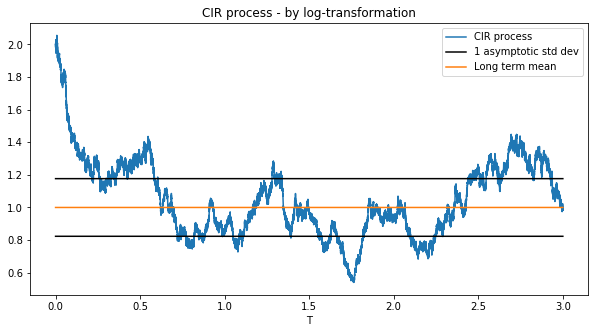

In [140]:
plt.figure(figsize=(10,5))
plt.plot(T_vec, np.exp(Y_1), label="CIR process")
plt.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
plt.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
plt.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
plt.legend(loc="upper right"); plt.title("CIR process - by log-transformation"); plt.xlabel("T")
plt.show()

As expected, the path did not change. (under same parameters and same seed as before). 
 
**This is (in my opinion) the best theoretical approach!** 

However, in practice, this is not the perfect method. It can have several problems for small values of $N$.     
For instance, as the algorithm involves an exponential function, it can generate huge numbers and even NaNs.


## References

[1]  Cox, J.C., Ingersoll, J.E and Ross, S.A. A Theory of the Term Structure of Interest Rates.
Econometrica, Vol. 53, No. 2 (March, 1985)